In [1]:
import dolfinx as dlx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from eikonax import preprocessing, solver, tensorfield
from mpi4py import MPI

from cardiac_electrophysiology import fibertensor

sns.set_theme(style="ticks")

In [2]:
mesh = dlx.mesh.create_rectangle(
    MPI.COMM_WORLD,
    [np.array([0, 0]), np.array([1, 1])],
    [100, 100],
    dlx.mesh.CellType.triangle,
)
vertices = mesh.geometry.x[:, :2]
simplices = mesh.geometry.dofmap
num_simplices = simplices.shape[0]

In [6]:
mean_angle_vector = np.full(num_simplices, 1 / 8 * np.pi)
mean_parameter_vector = np.arctanh(np.cos(mean_angle_vector + np.pi / 2))
first_basis_vector = np.repeat([[1, 0]], num_simplices, axis=0)
second_basis_vector = np.repeat([[0, 1]], num_simplices, axis=0)
longitudinal_velocity_vector = np.full(num_simplices, 5)
transversal_velocity_vector = np.full(num_simplices, 1)

fiber_tensor_settings = fibertensor.FiberTensorSettings(
    dimension=2,
    mean_angle_vector=mean_angle_vector,
    basis_vectors_one=first_basis_vector,
    basis_vectors_two=second_basis_vector,
    longitudinal_velocities=longitudinal_velocity_vector,
    transversal_velocities=transversal_velocity_vector,
)

In [7]:
fiber_tensor = fibertensor.FiberTensor(fiber_tensor_settings)
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_field_object = tensorfield.TensorField(
    num_simplices=num_simplices,
    vector_to_simplices_map=tensor_field_mapping,
    simplex_tensor=fiber_tensor,
)

solver_data = solver.SolverData(
    tolerance=1e-6,
    max_num_iterations=1000,
    max_value=1000,
    loop_type="jitted_while",
    use_soft_update=True,
    softminmax_order=20,
    softminmax_cutoff=0.01,
)
initial_site_ind = np.where((vertices[:,0] == 0) & (vertices[:,1] == 0))[0][0]
initial_sites = preprocessing.InitialSites(inds=(initial_site_ind,), values=(0,))
mesh_data = preprocessing.MeshData(mesh.geometry.x[:, :2], mesh.geometry.dofmap)
eikonax_solver = solver.Solver(mesh_data, solver_data, initial_sites)

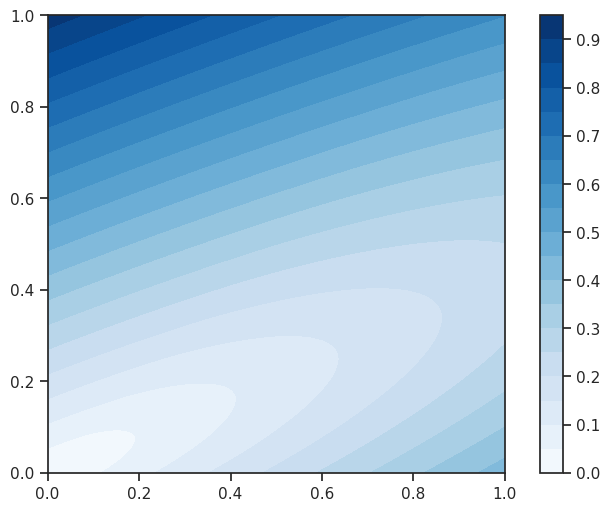

In [8]:
tensor_field_instance = tensor_field_object.assemble_field(mean_parameter_vector)
solution = eikonax_solver.run(tensor_field_instance)
solution_values = np.array(solution.values)

fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")
cp = ax.tricontourf(vertices[:, 0], vertices[:, 1], solution_values, levels=20, cmap="Blues")
plt.colorbar(cp)